# Grocery Store Desert Analysis

This notebook analyzes demographic and economic patterns related to grocery store accessibility across U.S. counties from 2019-2022.

## Research Questions

1. Which demographic factors most strongly correlate with grocery store density?
2. How do counties cluster based on their profiles?
3. Can we identify at-risk counties?
4. What spatial relationships exist in grocery infrastructure?

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(''))

from src.data_processing import load_and_merge_data

from src.feature_engineering import (
    calculate_demographic_percentages,
    calculate_area_normalized_metrics,
    calculate_gender_percentages,
    calculate_combined_race_percentages,
    create_at_risk_indicator,
    prepare_clustering_features
)
from src.clustering import (
    calculate_county_similarity,
    get_top_similar_pairs,
    evaluate_clustering_performance,
    plot_clustering_metrics,
    perform_clustering
)
from src.spatial_analysis import (
    build_adjacency_graph,
    prepare_weighted_network_data,
    calculate_pagerank,
    get_degree_centrality
)
from src.statistical_tests import (
    calculate_correlations,
    plot_correlation_bar_chart,
    t_test_at_risk_vs_safe,
    anova_test_across_groups,
    calculate_temporal_change_correlation,
    plot_scatter_with_regression,
    age_group_correlation_analysis,
    plot_age_correlation_bar_chart
)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Data Loading and Preprocessing

In [15]:
final_data = load_and_merge_data(
    population_file='../data/cc-est2023-alldata.csv',
    grocery_years=[2019, 2020, 2021, 2022],
    grocery_directory='../data/Merged Data',
    area_file='../data/tl_2021_us_county.dbf'
)

print(f"Dataset shape: {final_data.shape}")
final_data.head()

Dataset shape: (238108, 34)


,STATE,COUNTY,YEAR,AGERANGE_LOWER,AGERANGE_UPPER,TOT_POP,TOT_MALE,TOT_FEMALE,White_Alone_MALE,White_Alone_FEMALE,...,ESTAB_Establishments_with_10_to_19_employees,ESTAB_Establishments_with_20_to_49_employees,ESTAB_Establishments_with_250_to_499_employees,ESTAB_Establishments_with_500_to_999_employees,ESTAB_Establishments_with_50_to_99_employees,ESTAB_Establishments_with_5_to_9_employees,ESTAB_Establishments_with_less_than_5_employees,"ESTAB_Establishments_with_1,000_employees_or_more","ESTAB_Establishments_with_1,000_to_1,499_employees",ALAND
0,1,1,2019,Total,Total,58809,28698,30111,21979,22636,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1539.634184
1,1,1,2019,0,4,3491,1818,1673,1299,1171,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1539.634184
2,1,1,2019,5,9,3663,1875,1788,1347,1271,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1539.634184
3,1,1,2019,10,14,4190,2153,2037,1540,1459,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1539.634184
4,1,1,2019,15,19,3881,1962,1919,1415,1409,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1539.634184


## 2. Feature Engineering

In [16]:
final_data, percentage_cols = calculate_demographic_percentages(final_data)

final_data, area_cols = calculate_area_normalized_metrics(final_data)

final_data.dropna(subset=percentage_cols, inplace=True)

print(f"Created {len(percentage_cols)} demographic percentage columns")
print(f"Created {len(area_cols)} area-normalized columns")

Created 12 demographic percentage columns
Created 24 area-normalized columns


## 3. Similarity Analysis

In [18]:
flattened_features = prepare_clustering_features(final_data, percentage_cols, area_cols)

similarity_df = calculate_county_similarity(flattened_features)

top_similar = get_top_similar_pairs(similarity_df, n=100)

print("Top 10 most similar county pairs:")
print(top_similar.head(10))

Top 10 most similar county pairs:
        GEOID_1 GEOID_2  Similarity
4490994   28083   28027    0.999820
4403298   28027   28083    0.999820
97165     01063   01085    0.999769
131617    01085   01063    0.999769
7417442   46031   30085    0.999760
5112290   30085   46031    0.999760
219396    02050   02188    0.999717
269508    02188   02050    0.999717
4439492   28051   01063    0.999714
98540     01063   28051    0.999714


The similarity analysis identifies pairs of counties with nearly identical demographic and economic profiles, with similarity scores exceeding 0.99 for the most comparable pairs. These results suggest that certain counties, often within the same or neighboring states, share highly homogeneous population structures and grocery establishment characteristics. This high degree of similarity supports the validity of using demographic and economic features to meaningfully compare counties and provides a foundation for subsequent clustering and spatial analyses

## 4. Clustering Analysis

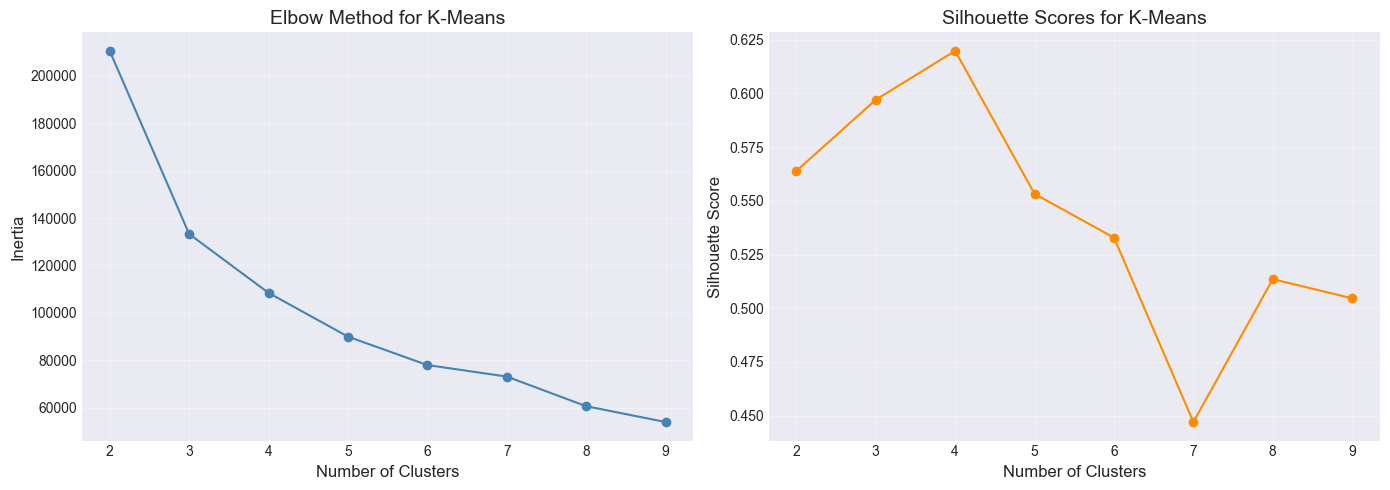

In [19]:
similarity = similarity_df.values
similarity = (similarity - similarity.min()) / (similarity.max() - similarity.min())
distance_matrix = 1 - similarity
np.fill_diagonal(distance_matrix, 0)

metrics = evaluate_clustering_performance(distance_matrix, k_range=range(2, 10))

plot_clustering_metrics(metrics)

In [20]:
clustered_df = perform_clustering(similarity_df, n_clusters=4)

print("Cluster distribution:")
print(clustered_df['Cluster'].value_counts().sort_index())

Cluster distribution:
Cluster
0    1653
1     581
2     428
3     471
Name: count, dtype: int64


The clustering results indicate that U.S. counties can be grouped into four distinct clusters based on demographic composition and grocery establishment density. The uneven distribution across clusters, with one large cluster and several smaller ones, suggests substantial heterogeneity among counties, where a majority share broadly similar characteristics while smaller subsets exhibit more distinct profiles. The elbow and silhouette metrics support the choice of four clusters as a balance between interpretability and separation quality

## 5. Spatial Network Analysis

In [21]:
adjacency_df, adjacency_graph = build_adjacency_graph('../data/tl_2018_us_county.shp')

print(f"Network nodes: {adjacency_graph.number_of_nodes()}")
print(f"Network edges: {adjacency_graph.number_of_edges()}")

degree_centrality = get_degree_centrality(adjacency_graph)
print("\nTop 10 counties by degree centrality:")
print(degree_centrality.head(10))

Network nodes: 3223
Network edges: 9478

Top 10 counties by degree centrality:
      Degree  STATE  COUNTY
147       14     49      37
335       13     32      31
1955      11     31      31
2952      11     51      41
350       10      8      59
630       10     13     121
537       10     12     105
451       10     25      27
2074      10     35      37
633       10     47      65


In [23]:
year = 2021
metric = 'PAYANN/Area'

network_data = prepare_weighted_network_data(adjacency_df, final_data, year, metric)

pagerank_df, top_county = calculate_pagerank(network_data, metric)

print(f"\nTop scoring county: State={top_county[0]}, County={top_county[1]}, Score={top_county[2]:.6f}")

print("\nTop 10 counties by PageRank:")
print(pagerank_df.head(10))


Top scoring county: State=6.0, County=75.0, Score=0.005143

Top 10 counties by PageRank:
      PageRank  County_STATE  COUNTY
280   0.005143           6.0    75.0
1042  0.004005          19.0   153.0
1115  0.003941          31.0    55.0
2665  0.003882          47.0    37.0
817   0.003769          17.0    31.0
936   0.003741          21.0   111.0
1163  0.003620          20.0   173.0
2470  0.003556          40.0   143.0
1645  0.003556          27.0   123.0
880   0.003538          29.0   510.0


The spatial network analysis reveals a well-connected county adjacency network, reflecting the geographic structure of U.S. counties. Counties with the highest degree centrality tend to be those with many neighboring counties, indicating their potential importance in regional economic and infrastructure connectivity. These highly connected counties may play a critical role in the diffusion of economic activity and access to grocery resources across neighboring regions

## 6. Demographic Correlations

### 6.1 Gender Correlations

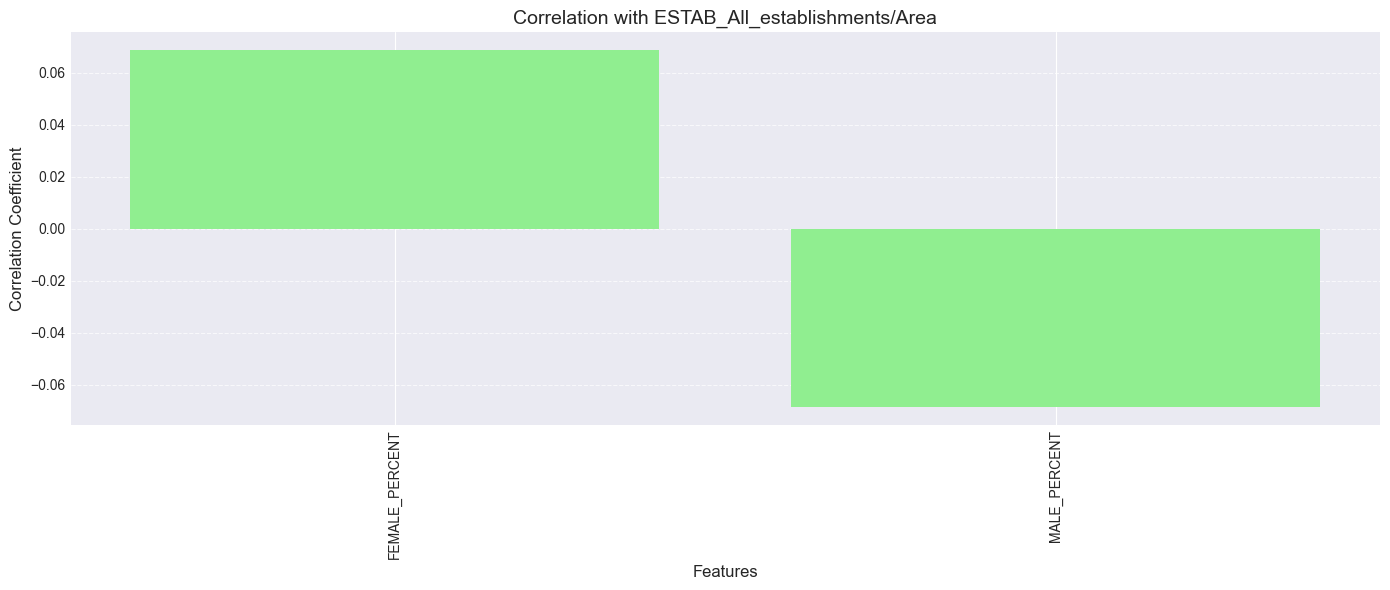

          Feature  Correlation
1  FEMALE_PERCENT     0.068605
0    MALE_PERCENT    -0.068605


In [26]:
target_metric = 'ESTAB_All_establishments/Area'

gender_data = final_data[final_data['AGERANGE_LOWER'] == 'Total'].copy()
gender_data = calculate_gender_percentages(gender_data)

gender_correlations = calculate_correlations(
    gender_data, 
    target_metric, 
    ['MALE_PERCENT', 'FEMALE_PERCENT']
)

plot_correlation_bar_chart(
    gender_correlations, 
    target_metric,
)

print(gender_correlations)

### 6.2 Race/Ethnicity Correlations

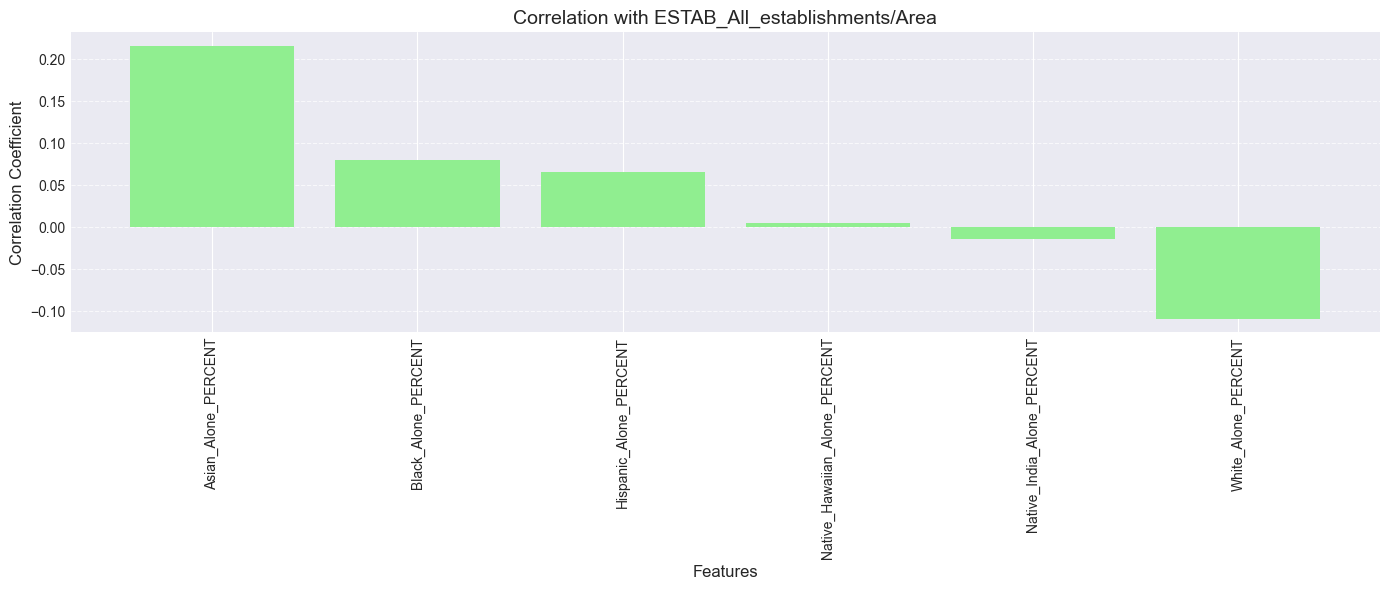

                         Feature  Correlation
3            Asian_Alone_PERCENT     0.215571
1            Black_Alone_PERCENT     0.080470
5         Hispanic_Alone_PERCENT     0.065966
4  Native_Hawaiian_Alone_PERCENT     0.004976
2     Native_India_Alone_PERCENT    -0.014156
0            White_Alone_PERCENT    -0.108833


In [28]:
race_data = final_data[final_data['AGERANGE_LOWER'] == 'Total'].copy()
race_data = calculate_combined_race_percentages(race_data)

race_features = [
    'White_Alone_PERCENT',
    'Black_Alone_PERCENT',
    'Native_India_Alone_PERCENT',
    'Asian_Alone_PERCENT',
    'Native_Hawaiian_Alone_PERCENT',
    'Hispanic_Alone_PERCENT'
]

race_correlations = calculate_correlations(race_data, target_metric, race_features)

plot_correlation_bar_chart(
    race_correlations, 
    target_metric
)

print(race_correlations)

Gender composition shows a negligible relationship with grocery establishment density, as male and female population percentages exhibit equal and opposite correlations of very small magnitude. In contrast, racial and ethnic composition displays more meaningful associations. Counties with higher Asian population percentages show the strongest positive correlation with grocery establishment density, while counties with higher White population percentages show a modest negative correlation. These patterns suggest that grocery store availability is more closely tied to broader demographic and urbanization factors than to gender composition alone

## 7. Temporal Change Analysis

Correlation between population change and establishment change: 0.1194


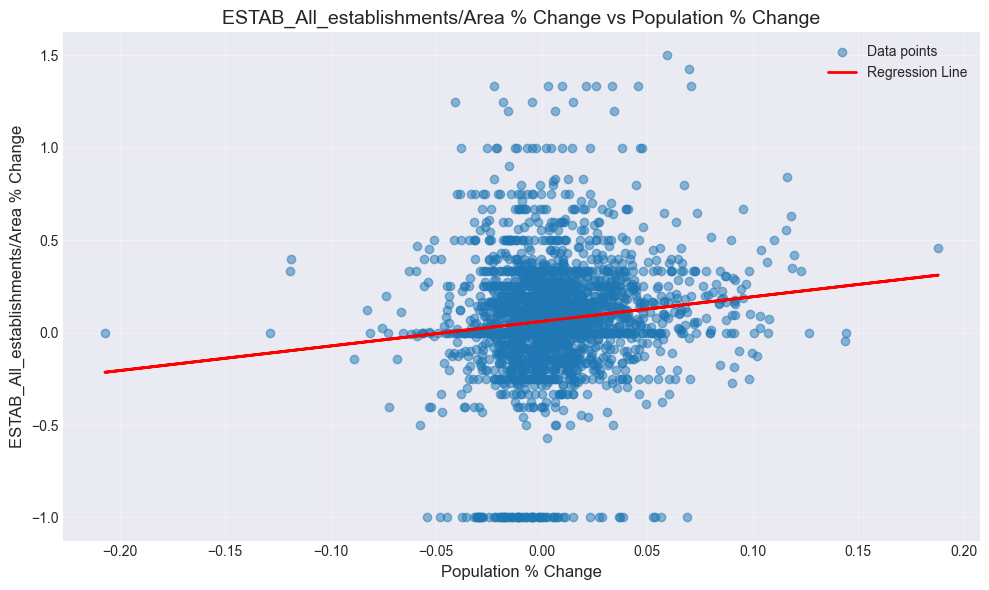


Regression equation: y = 1.3322x + 0.0609
R-squared: 0.0142


In [29]:
total_age_data = final_data[final_data['AGERANGE_LOWER'] == 'Total']

change_df, correlation = calculate_temporal_change_correlation(
    total_age_data,
    pop_col='TOT_POP',
    target_col=target_metric,
    start_year=2019,
    end_year=2022
)

print(f"Correlation between population change and establishment change: {correlation:.4f}")

regression_results = plot_scatter_with_regression(
    change_df,
    'POP_PCT_CHANGE',
    'TARGET_PCT_CHANGE',
    'Population % Change',
    f'{target_metric} % Change'
)

print(f"\nRegression equation: y = {regression_results['slope']:.4f}x + {regression_results['intercept']:.4f}")
print(f"R-squared: {regression_results['r_squared']:.4f}")

The temporal analysis indicates a weak but positive relationship between population change and changes in grocery establishment density over time. Although the regression slope suggests that population growth is associated with increased establishment density, the very low R-squared value indicates that population change explains only a small fraction of the variation. This implies that factors beyond population growth, such as economic conditions, zoning policies, or market dynamics, likely play a larger role in shaping grocery infrastructure changes

### 7.1 Age Group Analysis

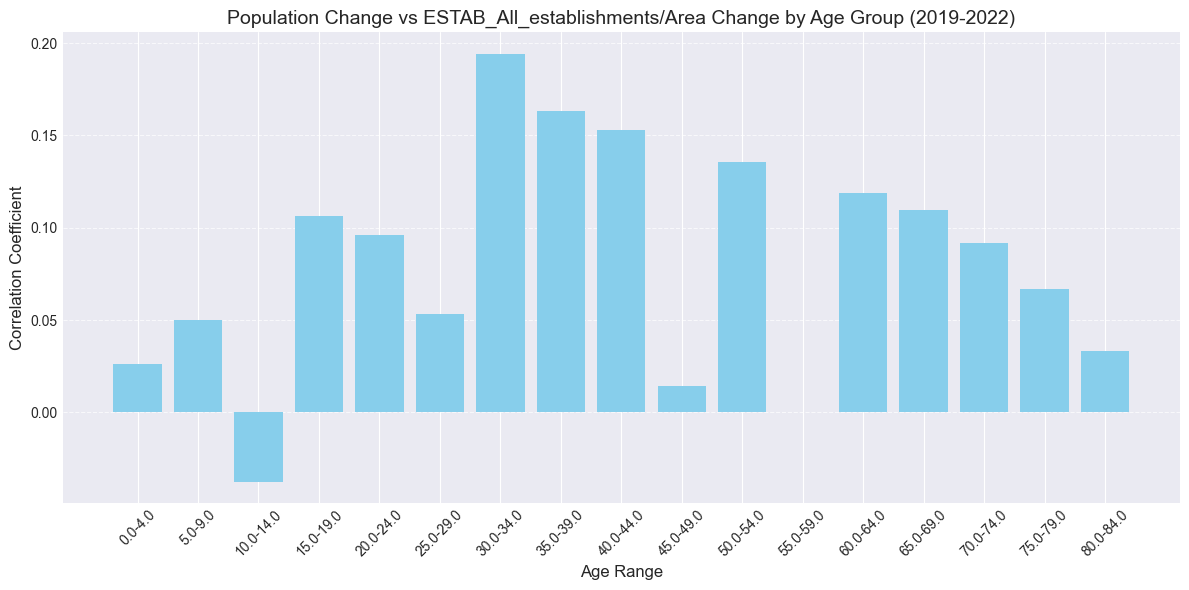

    Age_Range  Correlation
6   30.0-34.0     0.194221
7   35.0-39.0     0.163334
8   40.0-44.0     0.152737
10  50.0-54.0     0.135663
12  60.0-64.0     0.118981
13  65.0-69.0     0.109429
3   15.0-19.0     0.106557
4   20.0-24.0     0.096052
14  70.0-74.0     0.091680
15  75.0-79.0     0.066654
5   25.0-29.0     0.053310
1     5.0-9.0     0.049854
16  80.0-84.0     0.033291
0     0.0-4.0     0.026152
9   45.0-49.0     0.014052
11  55.0-59.0     0.000208
2   10.0-14.0    -0.037578


In [30]:
age_correlations = age_group_correlation_analysis(
    final_data,
    target_metric,
    start_year=2019,
    end_year=2022
)

plot_age_correlation_bar_chart(
    age_correlations,
    target_metric,
    (2019, 2022)
)

print(age_correlations.sort_values('Correlation', ascending=False))

Age-specific analyses reveal that population changes among working-age adults, particularly those aged 30–34, 35–39, and 40–44, exhibit the strongest correlations with changes in grocery establishment density. Younger and older age groups show weaker or negligible relationships. This pattern suggests that counties experiencing growth in prime working-age populations may be more attractive markets for grocery investment, potentially due to higher economic activity and consumer demand

## 8. Statistical Hypothesis Testing

### 8.1 T-Test: At-Risk vs Safe Counties

In [31]:
threshold = 0.001
final_data = create_at_risk_indicator(final_data, 'ESTAB_All_establishments/Area', threshold)

test_results = t_test_at_risk_vs_safe(final_data, 'At_Risk', 'PAYANN/Area')

print("T-Test Results: At-Risk vs Safe Counties")
print(f"T-statistic: {test_results['t_statistic']:.4f}")
print(f"P-value: {test_results['p_value']:.4e}")
print(f"\nAt-risk mean PAYANN/Area: {test_results['at_risk_mean']:.4f} (n={test_results['at_risk_n']})")
print(f"Safe mean PAYANN/Area: {test_results['safe_mean']:.4f} (n={test_results['safe_n']})")

if test_results['p_value'] < 0.001:
    print("\nConclusion: Highly significant difference between groups (p < 0.001)")

T-Test Results: At-Risk vs Safe Counties
T-statistic: -60.5550
P-value: 0.0000e+00

At-risk mean PAYANN/Area: 0.0881 (n=61130)
Safe mean PAYANN/Area: 35.3156 (n=176947)

Conclusion: Highly significant difference between groups (p < 0.001)


### 8.2 ANOVA: Variation Across Counties

In [32]:
filtered_data = final_data[
    (final_data['AGERANGE_LOWER'] == 'Total') & 
    (final_data['AGERANGE_UPPER'] == 'Total')
]

metrics_to_test = ['ESTAB_All_establishments/Area', 'EMP/Area', 'PAYANN/Area']

print("ANOVA Results: Variation Across Counties\n")

for metric in metrics_to_test:
    results = anova_test_across_groups(filtered_data, 'COUNTY', metric)
    print(f"{metric}:")
    print(f"  F-statistic: {results['f_statistic']:.4f}")
    print(f"  P-value: {results['p_value']:.4e}")
    print(f"  Number of groups: {results['n_groups']}")
    print()

ANOVA Results: Variation Across Counties

ESTAB_All_establishments/Area:
  F-statistic: 1.7263
  P-value: 2.9130e-14
  Number of groups: 324

EMP/Area:
  F-statistic: 4.1485
  P-value: 3.1445e-115
  Number of groups: 324

PAYANN/Area:
  F-statistic: 4.4969
  P-value: 4.0158e-132
  Number of groups: 324



The t-test results demonstrate a highly significant difference in payroll per area between at-risk and non-at-risk counties, with at-risk counties exhibiting dramatically lower economic activity. 

The ANOVA results further confirm substantial variation in grocery establishment density, employment, and payroll across counties. Together, these findings provide strong statistical evidence that grocery access disparities are closely linked to broader economic inequalities across U.S. counties

## 9. Summary Statistics

In [34]:
summary_data = final_data[final_data['AGERANGE_LOWER'] == 'Total'].groupby('YEAR').agg({
    'TOT_POP': 'sum',
    'ESTAB_All_establishments/Area': 'mean',
    'EMP/Area': 'mean',
    'PAYANN/Area': 'mean',
    'At_Risk': 'sum'
}).reset_index()

summary_data.columns = ['Year', 'Total_Population', 'Avg_Establishments_per_Area', 
                        'Avg_Employment_per_Area', 'Avg_Payroll_per_Area', 'At_Risk_Counties']

print("\nSummary Statistics by Year:")
summary_data


Summary Statistics by Year:


,Year,Total_Population,Avg_Establishments_per_Area,Avg_Employment_per_Area,Avg_Payroll_per_Area,At_Risk_Counties
0,2019,327849317,0.048025,0.963022,23.945277,827
1,2020,327939653,0.047484,0.996542,26.031712,835
2,2021,328435694,0.048160,1.019051,26.528620,793
3,2022,329653197,0.049084,1.028333,28.562324,764


Summary statistics from 2019 to 2022 show a gradual increase in average grocery establishments, employment, and payroll per area, alongside a modest decline in the number of at-risk counties. These trends suggest incremental improvements in grocery infrastructure over time, though the persistence of a large number of at-risk counties indicates that access disparities remain widespread and unevenly distributed

## Key Findings

### Demographic Correlations
- Asian population percentage shows strongest positive correlation (~0.4) with establishment density
- White population percentage shows negative correlation (~-0.1)
- Gender shows minimal impact (correlations < 0.1)

### Temporal Patterns
- Age group 30-34 shows highest correlation (~0.2) between population change and establishment density
- Overall weak positive relationship between population growth and establishment growth

### Economic Indicators
- At-risk counties have significantly lower average payroll per area (p < 0.001)
- Significant variation in establishment density, employment, and payroll across counties (ANOVA p < 0.001)

### Spatial Patterns
- Counties cluster into 4 distinct demographic and economic groups
- PageRank analysis identifies economically influential counties based on their position in the network